In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
sns.set_theme()

# Load data

In [14]:
train_data_path = '../input/heart-disease-prediction-tfug-chd-oct-2022/train.csv'
test_data_path = '../input/heart-disease-prediction-tfug-chd-oct-2022/test.csv'
train_full_data = pd.read_csv(train_data_path, index_col=0)
test_full_data = pd.read_csv(test_data_path, index_col=0)

# Look at data

In [15]:
train_full_data.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
index,,,,,,,,,,,,
0,72,1,2,136,209,1,0,111,1,-2.916701,3,1
1,61,1,3,113,341,0,0,186,1,1.317159,1,1
2,60,1,4,128,388,0,2,103,1,0.061226,1,0
3,65,1,3,136,201,1,2,142,0,1.230714,2,1
4,60,1,4,115,331,1,0,141,0,-0.162745,1,0


In [16]:
train_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  840 non-null    int64  
 1   sex                  840 non-null    int64  
 2   chest pain type      840 non-null    int64  
 3   resting bp s         840 non-null    int64  
 4   cholesterol          840 non-null    int64  
 5   fasting blood sugar  840 non-null    int64  
 6   resting ecg          840 non-null    int64  
 7   max heart rate       840 non-null    int64  
 8   exercise angina      840 non-null    int64  
 9   oldpeak              840 non-null    float64
 10  ST slope             840 non-null    int64  
 11  target               840 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 85.3 KB


In [18]:
y_train = train_full_data.loc[:, "target"]
X_train = train_full_data.iloc[:, :-1]

Determine types of features.

In [19]:
num_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
cat_string_to_ordinal_cols = []
cat_string_to_one_hot_cols = []
cat_ordinal_cols = ['ST slope']
cat_to_one_hot_cols = ['exercise angina', 'sex', 'chest pain type', 'fasting blood sugar', 'resting ecg']
target_column = ['target']

In [21]:
original_col_number = len(train_full_data.columns) - 1
divided_col_sum_number = len(
    set(num_cols + cat_string_to_ordinal_cols + cat_string_to_one_hot_cols + cat_ordinal_cols + cat_to_one_hot_cols))
assert original_col_number == divided_col_sum_number, f"The original col number = {original_col_number}, differs from the divided_col_sum_number = {divided_col_sum_number}"

# Visualize data

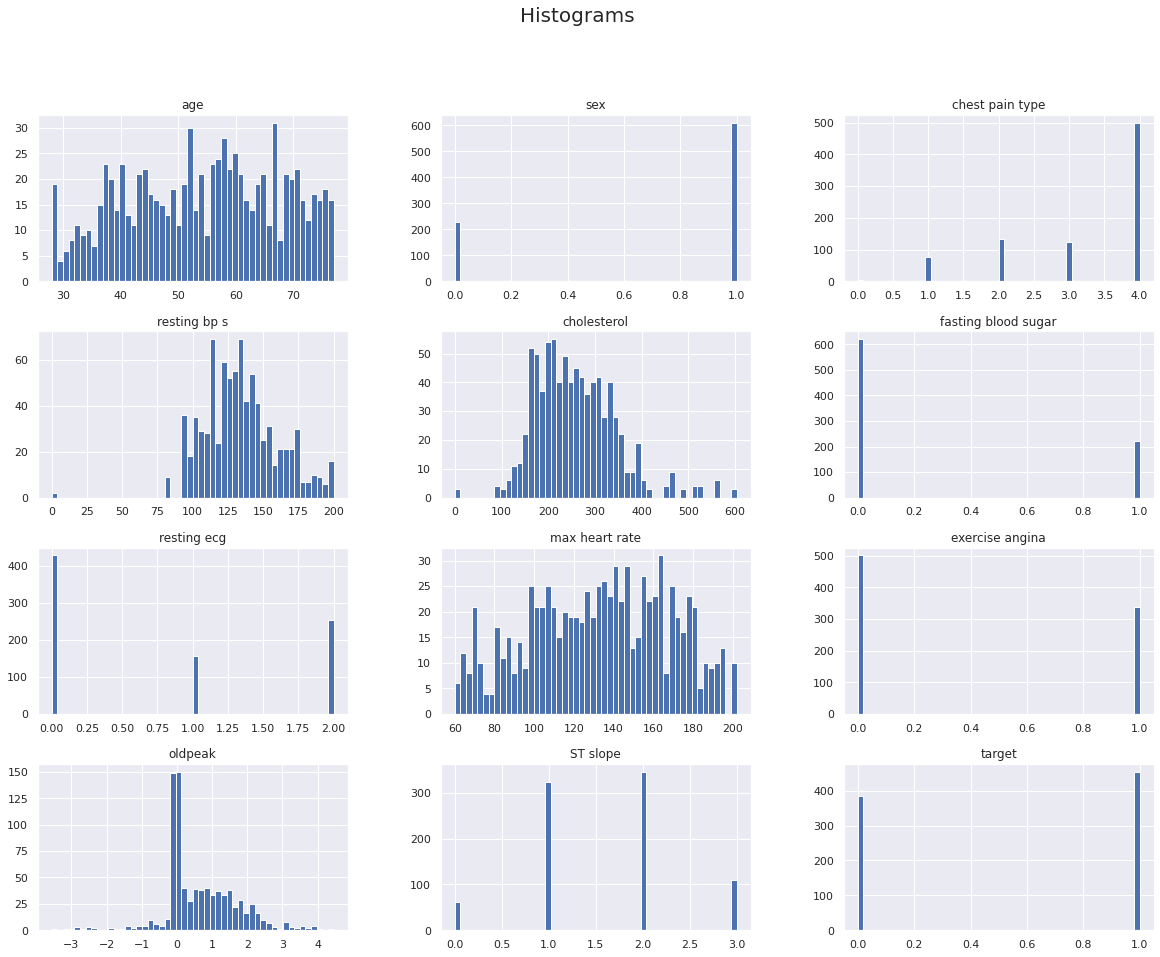

In [29]:
train_full_data.hist(bins=50, figsize=(20, 15))
plt.gcf().suptitle("Histograms", fontsize=20)
plt.show()

Looking for correlations

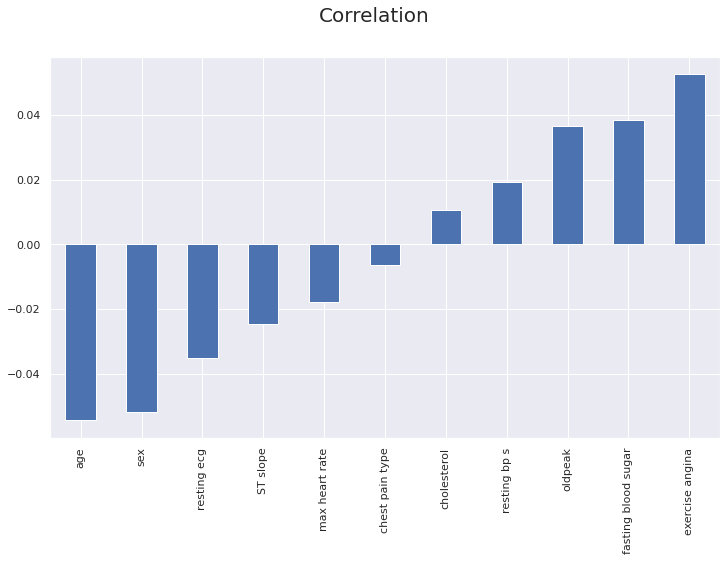

In [32]:
corr = train_full_data.corr()
plt.figure(figsize=(12, 7))
plt.gcf().suptitle("Correlation", fontsize=20)
corr["target"][:-1].sort_values().plot.bar();

No missing values.

# Create Pipeline

In [33]:
cat_one_hot_encoder = OneHotEncoder(cols=cat_to_one_hot_cols + cat_string_to_one_hot_cols)
#note: it will give always one hot encoded EVEN for binary data
#use sklearn onehot for that functionality and add it to column transformer

In [34]:
cat_ordinal_encoder = OrdinalEncoder(cols=cat_string_to_ordinal_cols)

In [35]:
normalizer = Normalizer()
numerical_normalizer = ColumnTransformer([("numerical_normalizer", normalizer, num_cols)], remainder="passthrough")

In [36]:
pf = PolynomialFeatures(2)
polynomial_features = ColumnTransformer([("polynomial_features", pf, num_cols)], remainder="passthrough")

In [37]:
st = SplineTransformer(degree=2, n_knots=3)
spline_transformer = ColumnTransformer([("spline_transformer", st, num_cols)], remainder="passthrough")

In [40]:
def get_data_pipeline(additional_features=None):
    """
    Creates data preprocessing pipeline.
    Args:
        additional_features: {'None', 'PolynomialFeatures', 'SpineFeatures'}
    """
    pipeline_list = [
        ("cat_one_hot_encoder", cat_one_hot_encoder),
        ("cat_ordinal_encoder", cat_ordinal_encoder),
        ("numerical_normalizer", numerical_normalizer)
    ]
    if additional_features == "PolynomialFeatures":
        pipeline_list.append(("polynomial_features", polynomial_features))
    elif additional_features == "SpineFeatures":
        pipeline_list.append(("spline_transformer", spline_transformer))
    else:
        pass
    return Pipeline(pipeline_list)

In [42]:
data_pipeline = get_data_pipeline()
data_pipeline.fit_transform(X_train)[:2]

array([[ 0.25505227,  0.48176541,  0.74036008,  0.39320559, -0.0103321 ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  3.        ],
       [ 0.14910516,  0.27621119,  0.83352228,  0.45464852,  0.00321959,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ]])

In [44]:
def get_full_pipeline(model, data_pipeline=None):
    if data_pipeline is None:
        data_pipeline = get_data_pipeline()
    return Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])

In [49]:
scoring_metrics = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "log_loss": make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}

In [56]:
models = {
    "LogisticRegression": LogisticRegression(),
    "Support Vector Classifier": SVC(probability=True),

    "KNeighborsClassifier": KNeighborsClassifier(),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),

    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(),

    "GaussianNB": GaussianNB(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
}

## Cross validation

In [101]:
cv_results_mean = {}
cv_results_std = {}
for model_name, model in models.items():
    print(f"CV on {model_name}")
    pipeline = get_full_pipeline(model)
    gs = cross_validate(pipeline, X_train, y_train, scoring=scoring_metrics, verbose=1, n_jobs=-1)
    cv_results_mean[model_name] = {
        "mean_accuracy": np.mean(gs["test_accuracy"]),

        "mean_f1": np.mean(gs["test_f1"]),

        "mean_precision": np.mean(gs["test_precision"]),

        "mean_recall": np.mean(gs["test_recall"]),

    }
    cv_results_std[model_name] = {
        "std_accuracy": np.std(gs["test_accuracy"]),
        "std_f1": np.std(gs["test_f1"]),
        "std_precision": np.std(gs["test_precision"]),
        "std_recall": np.std(gs["test_recall"]),
    }

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on LogisticRegression


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on Suport Vector Classifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on KNeighborsClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on LinearDiscriminantAnalysis


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on DecisionTreeClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on RandomForestClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on XGBClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on GaussianNB


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on AdaBoostClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV on GradientBoostingClassifier


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [102]:
cv_results_mean = pd.DataFrame(cv_results_mean).T
cv_results_std = pd.DataFrame(cv_results_std).T

In [109]:
cm = sns.light_palette("green", as_cmap=True)

cv_results_mean.style.background_gradient(cmap=cm)

,mean_accuracy,mean_f1,mean_precision,mean_recall
LogisticRegression,0.520238,0.625796,0.540994,0.744396
Suport Vector Classifier,0.546429,0.633771,0.562198,0.726862
KNeighborsClassifier,0.507143,0.551448,0.542010,0.561538
LinearDiscriminantAnalysis,0.513095,0.606413,0.538078,0.695995
DecisionTreeClassifier,0.498810,0.532076,0.535761,0.530940
RandomForestClassifier,0.533333,0.591401,0.561887,0.625617
XGBClassifier,0.551190,0.596562,0.579966,0.616947
GaussianNB,0.503571,0.460851,0.438171,0.497900
AdaBoostClassifier,0.548810,0.617502,0.571054,0.674090
GradientBoostingClassifier,0.538095,0.601511,0.563070,0.647497


In [105]:
def plot_model_comparison(metric):
    plt.figure(figsize=(12, 7))
    plt.title(f"Model {metric} comparison", fontsize=20)
    plt.bar(list(range(len(cv_results_mean))), cv_results_mean.loc[:, f"mean_{metric}"],
            yerr=cv_results_std[f"std_{metric}"])
    plt.xticks(list(range(len(cv_results_mean))), cv_results_mean.index.values, fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()

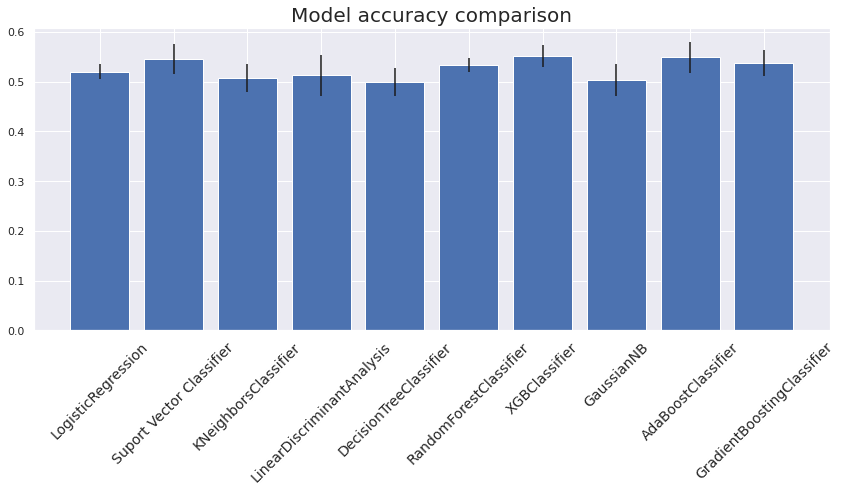

In [106]:
plot_model_comparison("accuracy")

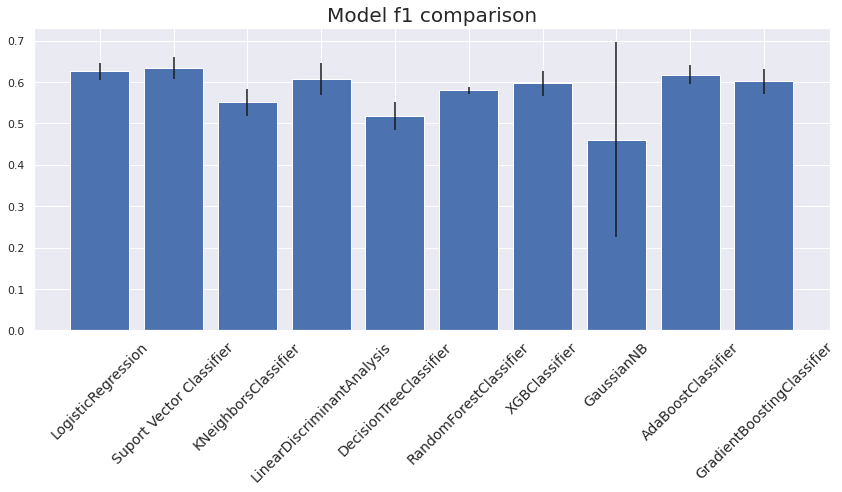

In [96]:
plot_model_comparison("f1")

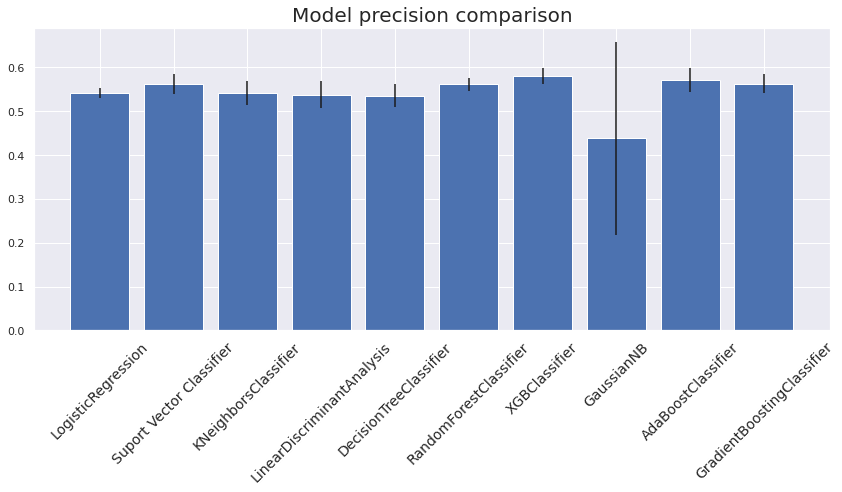

In [107]:
plot_model_comparison("precision")

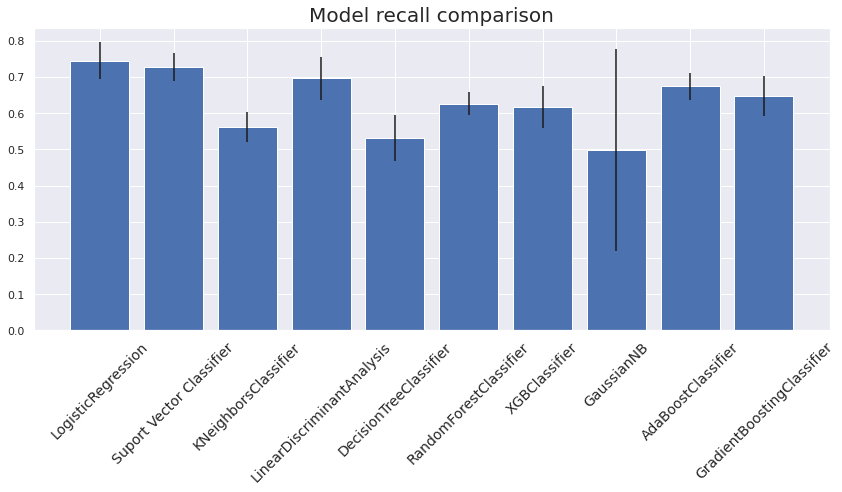

In [108]:
plot_model_comparison("recall")

## Grid Search

It's very time consuming to check all the parameters.

In [ ]:
model_name_to_params = {
    "LogisticRegression": [{
        "model__penalty": ["elasticnet"],
        "model__C": [0.01, 0.03, 0.1, 0.3, 1., 3., 10., 30.],
        "model__class_weight": [None, "balanced"],
        "model__l1_ratio": [0., 0.1, 0.3, 0.5, 0.7, 0.9, 1.],
        "model__solver": ["saga"]
    }, ],
    "Support Vector Classifier": {  #better not use that if the predic_proba is needed
        "model__C": [0.01, 0.03, 0.1, 0.3, 1., 3., 10., 30.],
        "model__kernel": ["linear", "rbf", "sigmoid"],
        "model__gamma": ["scale", "auto"],
        "model__shrinking": [True, False]
    },

    "KNeighborsClassifier": {
        "model__n_neighbors": [1, 3, 5, 10, 15],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],

    },
    "LinearDiscriminantAnalysis": {
        "model__shrinkage": [None, "auto"],
    },

    "DecisionTreeClassifier": {
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__splitter": ["best", "random"],
        "model__max_depth": [3, 5, 10, 15, 21, 30, 45, None],
        "model__min_samples_split": [2, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
    "RandomForestClassifier": {
        "model__class_weight": [None, "balanced"],
        "model__n_estimators": [30, 100, 300],
        "model__criterion": ["gini", "entropy"],
        "model__max_features": ["auto", "sqrt", "log2"],
        "model__bootstrap": [True, False],
    },

    "GaussianNB": {

    },
    "AdaBoostClassifier": {
        "model__n_estimators": [10, 30, 50, 100, 300],
        "model__learning_rate": [0.01, 0.03, 0.1, 0.3, 1., 3., 10.],
    },
    "GradientBoostingClassifier": {
        "model__loss": ["log_loss", "exponential"],
        "model__learning_rate": [0.03, 0.1, 0.3],
        "model__n_estimators": [30, 100, 300],
        "model__criterion": ["friedman_mse"],
        "model__max_depth": [3, 5, 10, 15, 21, 30, 45],
        "model__max_features": ["auto", None],
    },
    "XGBClassifier": {
        "model__n_estimators": [16, 32, 48]
    },
}

In [ ]:
best_models = {}
cv_results = {}
for model_name, model in models.items():
    print(f"Grid Search CV on {model_name}")
    pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    gs = GridSearchCV(pipeline, model_name_to_params[model_name], scoring=scoring_metrics, refit="f1", verbose=1,
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    print(model_name)
    print(gs.best_score_)
    print(gs.cv_results_['params'][gs.best_index_])
    best_models[model_name] = gs.best_estimator_
    cv_results[model_name] = gs.cv_results_

In [ ]:
best_model = "XGBClassifier"
pred = best_models[best_model].predict_proba(test_full_data)[:, 1]

In [ ]:
sub = pd.DataFrame(pred, columns=["target"])
sub = sub.reset_index()
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.head()

Acctually it's a small dataset so in that case, the number of features might be reduced and more specific models for small dataset should be furhter analysed.